<a href="https://colab.research.google.com/github/KhuyenLE-maths/CIFAR-10-recognition-with-CNN/blob/main/CIFAR10_recognition_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os 
os.chdir('/content/drive/MyDrive/Cifar-10 object recognition with CNN/')

### The CIFAR-10 dataset 
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images.

- The test batch contains exactly 1000 randomly-selected images from each class.
- The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another.

Between them, the training batches contain exactly 5000 images from each class.

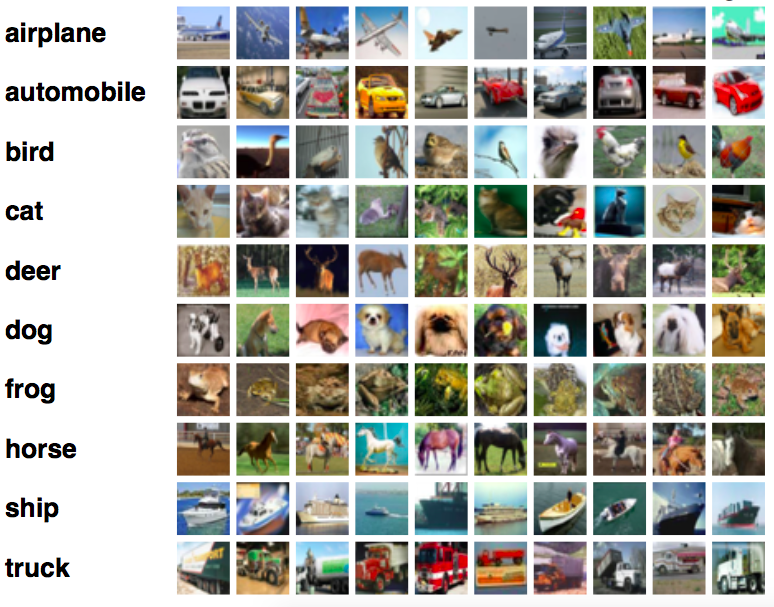

### Load dataset

In [3]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
print('Train: X = %s, y = %s', (X_train.shape, y_train.shape))
print('Test: X = %s, y = %s', (X_test.shape, y_test.shape))

Train: X = %s, y = %s ((50000, 32, 32, 3), (50000, 1))
Test: X = %s, y = %s ((10000, 32, 32, 3), (10000, 1))


### Visualize randomly some images 

In [5]:
import matplotlib.pyplot as plt
import random

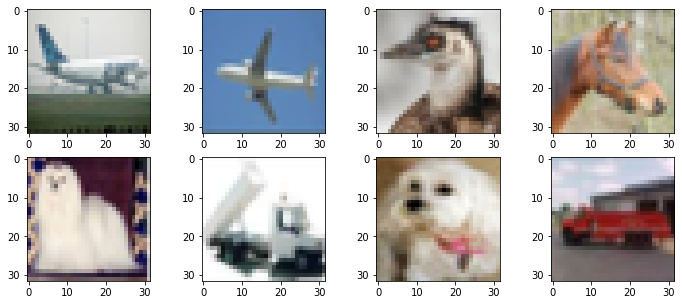

In [6]:
plt.figure(figsize = (12,5))
for i in range(8):
  ind = random.randint(0,len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])

plt.show()

One-hot encoding labels 

In [7]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)

In [8]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def load_dataset():
  (X_train, y_train), (X_test, y_test) = cifar10.load_data()
  # one hot encode target values 
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  return X_train, y_train, X_test, y_test

In [10]:
# scale pixels 
def prep_pixels(train, test):
  # convert from intergers to floats 
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  # normalize to range 0-1
  train_norm = train_norm/255.0
  test_norm = test_norm/255.0
  return train_norm, test_norm

In [11]:
def summarize_diagnostics(history):
  # plot loss 
  plt.subplot(211)
  plt.plot(history.history['loss'], color = 'blue', label = 'train')
  plt.plot(history.history['val_loss'], color = 'red', label = 'val')
  plt.legend()
  # plot accuracy
  plt.subplot(212)
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  #plt.show()
  #plt.close()

Run test harness for evaluating the model

In [12]:
def run_test_harness(model, path_checkpoint):
  # load dataset
  X_train, y_train, X_test, y_test = load_dataset()
  # prepare pixel data
  X_train, X_test = prep_pixels(X_train, X_test)
  # fit model 
  history = model.fit(X_train, y_train, epochs = 200, batch_size = 128, validation_data = (X_test, y_test), verbose = 1)
  # evaluate model 
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  # learning curves 
  summarize_diagnostics(history)

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [14]:
def run_test_harness_with_data_aug(model):
  # load dataset
  X_train, y_train, X_test, y_test = load_dataset()
  # prepare pixel data
  X_train, X_test = prep_pixels(X_train, X_test)
  # create data generator
  datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size = 64)
  # fit model
  path_cp = os.getcwd() + "/" + "weights_.hdf5"
  checkpoint_model = ModelCheckpoint(path_cp, monitor = "loss", save_best_only = True, mode = "auto")
  steps = X_train.shape[0]//64
  history = model.fit_generator(it_train, epochs = 200, steps_per_epoch = steps, validation_data = (X_test, y_test), verbose = 1, callbacks = checkpoint_model)
  # evaluate model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc*100.0))
  # learning curves
  summarize_diagnostics(history)

In [15]:
os.getcwd()

'/content/drive/MyDrive/Cifar-10 object recognition with CNN'

### Build CNN model
(Combine dropout, weight decay (weight regularization), data augmentation, batch normalization)

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2

In [17]:
def define_model():
  model = Sequential()
  # layer 1
  model.add(Conv2D(filters = 32, kernel_size = (7,7), kernel_regularizer = l2(0.02), padding = 'same', activation = 'relu', input_shape = (32,32,3)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters = 32, kernel_size = (7,7), kernel_regularizer = l2(0.02), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))
  # layer 2
  model.add(Conv2D(filters = 64, kernel_size = (5,5), kernel_regularizer = l2(0.02), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters = 64, kernel_size = (5,5), kernel_regularizer = l2(0.02), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.4))
  # layer 3
  model.add(Conv2D(filters = 128, kernel_size = (3,3), kernel_regularizer = l2(0.02), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters = 128, kernel_size = (3,3), kernel_regularizer = l2(0.02), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.35))
  # fully connected layer 
  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer = l2(0.01), activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'softmax'))
  # compile model 
  opt = SGD(lr = 0.001)
  model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model 

In [18]:
model = define_model()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
781/781 [==============================] - 34s 34ms/step - loss: 12.4866 - accuracy: 0.1486 - val_loss: 11.1552 - val_accuracy: 0.2434
Epoch 2/200
781/781 [==============================] - 26s 34ms/step - loss: 11.1222 - accuracy: 0.2326 - val_loss: 10.4777 - val_accuracy: 0.3358
Epoch 3/200
781/781 [==============================] - 27s 34ms/step - loss: 10.5113 - accuracy: 0.2742 - val_loss: 9.9154 - val_accuracy: 0.3804
Epoch 4/200
781/781 [==============================] - 26s 34ms/step - loss: 9.9690 - accuracy: 0.3146 - val_loss: 9.4780 - val_accuracy: 0.3861
Epoch 5/200
781/781 [==============================] - 27s 34ms/step - loss: 9.4815 - accuracy: 0.3356 - val_loss: 9.0465 - val_accuracy: 0.4024
Epoch 6/200
781/781 [==============================] - 26s 34ms/step - loss: 9.0232 - accuracy: 0.3633 - val_loss: 8.5082 - val_accuracy: 0.4541
Epoch 7/200
781/781 [==============================] - 26s 34ms/step - loss: 8.5970 - accuracy: 0.3806 - val_loss: 8.1332 - v

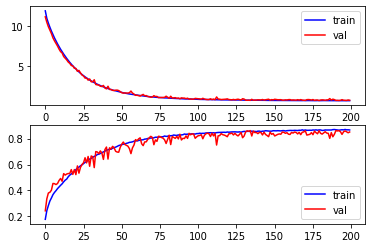

In [19]:
run_test_harness_with_data_aug(model)

In [20]:
model.save("model.h5")

## Make prediction

In [ ]:
import numpy as np

In [ ]:
y_test_pred = []
for i in np.arange(len(X_test)):
  img = X_test[i]
  img = img.reshape(1,32,32,3)
  img = img.astype('float32')
  img = img/255.0
  vector_p = model.predict(img)
  y_p = np.argmax(vector_p)
  y_test_pred.append(y_p)

#print(y_test_pred)

In [41]:
print([type(y_test_pred), type(y_test)])

[<class 'list'>, <class 'numpy.ndarray'>]


In [43]:
y_test_pred = np.asarray(y_test_pred)
type(y_test_pred)

numpy.ndarray

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
confusion_mat = confusion_matrix(y_test, y_test_pred)

In [48]:
import matplotlib.pyplot as plt 
import seaborn as sns

Text(69.0, 0.5, 'True classes')

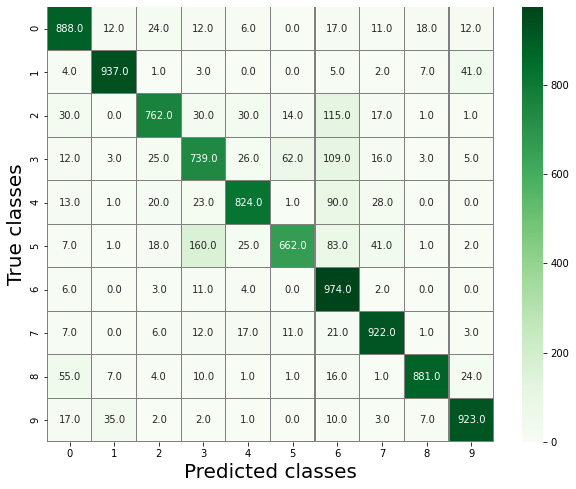

In [52]:
plt.figure(figsize = (10,8))
sns.heatmap(confusion_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

### Visualize randomly some images and their predicted classes 

In [53]:
import random

In [54]:
Cats = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'struck']

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


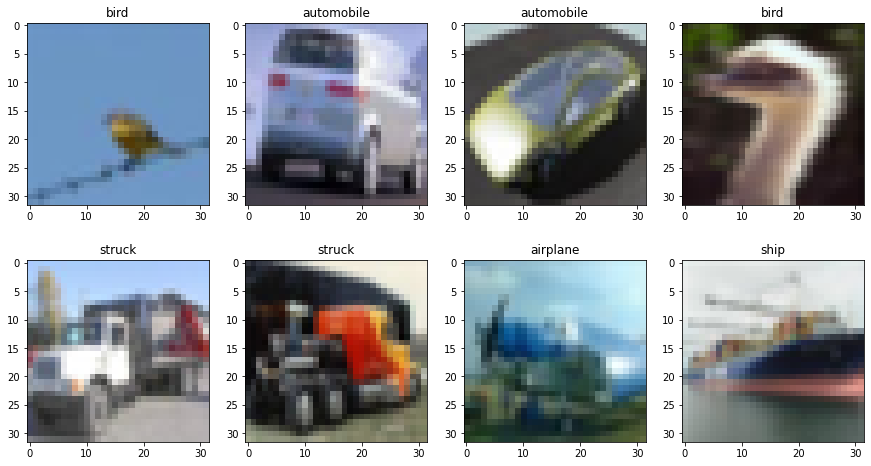

In [79]:
plt.figure(figsize = (15,8))
for i in np.arange(8):
  ind = random.randint(0,len(X_test))
  img = X_test[ind]
  img = img.reshape(1,32,32,3)
  img = img.astype('float32')
  img = img/255.0
  v_p = model.predict_classes(img)
  plt.subplot(240+1+i)
  plt.imshow(X_test[ind])
  plt.title(Cats[v_p[0]])